In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/ML/HAI817_Projet_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ML/HAI817_Projet_test.csv')

In [ ]:
# Importation des différentes librairies, classes et fonctions utilespour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# librairies générales
import pandas as pd
import re
from tabulate import tabulate
import time
import numpy as np
import pickle
import string
import base64
import sys

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns

# librairies scikit learn
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# librairies des classifiers utilisés
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# librairies NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize 

 
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
my_local_drive='/content/drive/MyDrive/ML/Prof/ML_FDS'

# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
#%cd $my_local_drive

#%pwd

# fonctions utilities (affichage, confusion, etc.)
from MyNLPUtilities import *

In [ ]:
df_all = pd.concat([df_train,df_test])


Encodage des classes selon la 1-re tache de classification true / false

In [ ]:
df_all = df_all[~df_all['our rating'].isin(['mixture', 'other'])]

df_all['classe'] = df_all['our rating'].map({'true': 1, 'false': 2})

<ipython-input-6-c7b19893d15a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['classe'] = df_all['our rating'].map({'true': 1, 'false': 2})


In [ ]:
print(df_all["classe"].value_counts())

2    893
1    421
Name: classe, dtype: int64


Equilibrage des classes

In [ ]:
from sklearn.utils import resample
import pandas as pd



# Séparer les classes majoritaires et minoritaires
df_majority = df_all[df_all['classe'] == 2]
df_minority = df_all[df_all['classe'] == 1]

# Sous-échantillonner la classe majoritaire
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # Échantillonnage sans remplacement
                                   n_samples=len(df_minority), # Nombre d'échantillons égal à la classe minoritaire
                                   random_state=42)  # Pour la reproductibilité

# Combiner les classes majoritaire et minoritaire
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Afficher la taille du jeu de données équilibré
print("Taille du jeu de données équilibré : ", df_balanced.shape)

df_all = df_balanced
print(df_all['classe'].value_counts())

Taille du jeu de données équilibré :  (842, 6)
2    421
1    421
Name: classe, dtype: int64


Définition de la fonction  MyCleanText

In [ ]:
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def MyCleanText(X,
 lowercase=False, # mettre en minuscule
 removestopwords=False, # supprimer les stopwords
 removedigit=False, # supprimer les nombres
 getstemmer=False, # conserver la racine des termes
 getlemmatisation=False # lematisation des termes
 ):
    
    sentence = str(X)
    
    # suppression des caractères spéciaux
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    
    # suppression de tous les caractères uniques
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    
    # substitution des espaces multiples par un seul espace
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)
    
    # decoupage en mots
    tokens = word_tokenize(sentence)
    
    if lowercase:
        tokens = [token.lower() for token in tokens]

    # suppression ponctuation
    table = str.maketrans('', '', string.punctuation)
    words = [token.translate(table) for token in tokens]
    
    # suppression des tokens non alphabetique ou numerique
    words = [word for word in words if word.isalnum()]

    # suppression des tokens numerique
    if removedigit:
        words = [word for word in words if not word.isdigit()]
    
    # suppression des stopwords
    if removestopwords:
        words = [word for word in words if not word in stop_words]
    
    # lemmatisation
    if getlemmatisation:
        lemmatizer=WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word)for word in words]
    
    # racinisation
    if getstemmer:
        ps = PorterStemmer()
        words=[ps.stem(word) for word in words]

    sentence= ' '.join(words)

    return sentence


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Définition de la fonction TextNormalizer

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 removestopwords=False, # suppression des stopwords
                 lowercase=False,# passage en minuscule
                 removedigit=False, # supprimer les nombres
                 getstemmer=False,# racinisation des termes
                 getlemmatisation=False # lemmatisation des termes
                ):
        self.lowercase=lowercase
        self.getstemmer=getstemmer
        self.removestopwords=removestopwords
        self.getlemmatisation=getlemmatisation
        self.removedigit=removedigit
    
    def transform(self, X, **transform_params):
        # Nettoyage du texte
        X=X.copy() # pour conserver le fichier d'origine
        return [MyCleanText(text, lowercase=self.lowercase,
                            getstemmer=self.getstemmer,
                            removestopwords=self.removestopwords,
                            getlemmatisation=self.getlemmatisation,
                            removedigit=self.removedigit) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X).transform(X)
    
    def get_params(self, deep=True):
        return {
            'lowercase':self.lowercase,
            'getstemmer':self.getstemmer,
            'removestopwords':self.removestopwords,
            'getlemmatisation':self.getlemmatisation,
            'removedigit':self.removedigit
        }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


In [ ]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 62.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatibl

In [ ]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # do something here and its warning is suppressed

# librairies générales
import pandas as pd
import re
import time
import numpy as np
import string
import base64

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns


# librairies pour LDA

import pyLDAvis


# librairies scikit learn
import sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report


# librairies NLTK
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize 
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet


# librairie spacy
import spacy

# librairies de gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import corpora
from gensim import models




 
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

# chargement spacy en (english)
!python3 -m spacy download en

/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Pa

2023-04-29 15:20:44.407972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Nettoyage de texte pour l'analyse de sujet avec LDA et création de dictionnaire et corpus avec Gensim

In [ ]:
import re
import spacy
import gensim
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import corpora
from gensim import models
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
#nlp = spacy.load('en', disable=['parser', 'ner'])

def MyCleanTextsforLDA(texts,
                      min_count=1, # nombre d'apparitions minimale pour un bigram
                      threshold=2, 
                      no_below=1, # nombre minimum d'apparitions pour être dans le dictionnaire
                      no_above=0.5, # pourcentage maximal (sur la taille totale du corpus) pour filtrer
                      stop_words=stop_words
                      ):
    
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    sentences=texts.copy()
    
    # suppression des caractères spéciaux
    sentences = [re.sub(r'[^\w\s]', ' ', str(sentence)) for sentence in sentences]
    # suppression de tous les caractères uniques
    sentences = [re.sub(r'\s+[a-zA-Z]\s+', ' ', str(sentence)) for sentence in sentences]
    # substitution des espaces multiples par un seul espace
    sentences = [re.sub(r'\s+', ' ', str(sentence), flags=re.I) for sentence in sentences]
    
    # conversion en minuscule et split des mots dans les textes
    sentences = [sentence.lower().split() for sentence in sentences]
    
    # utilisation de spacy pour ne retenir que les allowed_postags
    texts_out = []
    for sent in sentences:
        if len(sent) < (nlp.max_length): # si le texte est trop grand
            doc = nlp(" ".join(sent)) 
            texts_out.append(" ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags]))
        else: 
            texts_out.append(sent)    
    sentences=texts_out 
    
    # suppression des stopwords
    words =[[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in sentences]
    
    
    # recherche des bigrammes
    bigram = Phrases(words, min_count, threshold,delimiter=' ')
    bigram_phraser = Phraser(bigram)
    
    
    # sauvergarde des tokens et des bigrammes
    bigram_token = []
    for sent in words:
        bigram_token.append(bigram_phraser[sent])
        
    
    # creation du vocabulaire
    dictionary = gensim.corpora.Dictionary(bigram_token)

    
    # il est possible de filtrer des mots en fonction de leur occurrence d'apparitions
    #dictionary.filter_extremes(no_below, no_above)
    # et de compacter le dictionnaire
    # dictionary.compactify()
    corpus = [dictionary.doc2bow(text) for text in bigram_token]
    
    # recuperaction du tfidf plutôt que uniquement le bag of words
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    return corpus, corpus_tfidf, dictionary, bigram_token

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Prétraitement de texte avec enrichissement des stopwords et application de LDA sur un corpus complet

In [ ]:
stop = stopwords.words('english')

# enrichissement des stopwords 
stop.extend(['always','try','go','get','make','would','really',
                  'like','came','got'])
corpus_all, corpus_tfidf_all, dictionary_all, bigram_token_all=MyCleanTextsforLDA(df_all.text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Obtenir les valeurs de cohérence optimales pour les modèles LDA à différents nombres de sujets

In [ ]:
def get_best_coherence_values(corpus, dictionary, listtokens, start=5, stop=15, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
        coherence_model_lda = CoherenceModel(model=lda_model, texts=listtokens, dictionary=dictionary, coherence='c_v')
        model_list.append(lda_model)
        coherence_values.append(coherence_model_lda.get_coherence())
    return model_list, coherence_values



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Spécification de la plage de nombre de sujets

In [ ]:

start=12
stop=25
step=2
model_list, coherence_values = get_best_coherence_values(dictionary=dictionary_all, 
                                                        corpus=corpus_all, 
                                                        listtokens=bigram_token_all, 
                                                        start=start, stop=stop, step=step)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Visualisation des valeurs de cohérence en fonction du nombre de sujets pour les modèles LDA

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


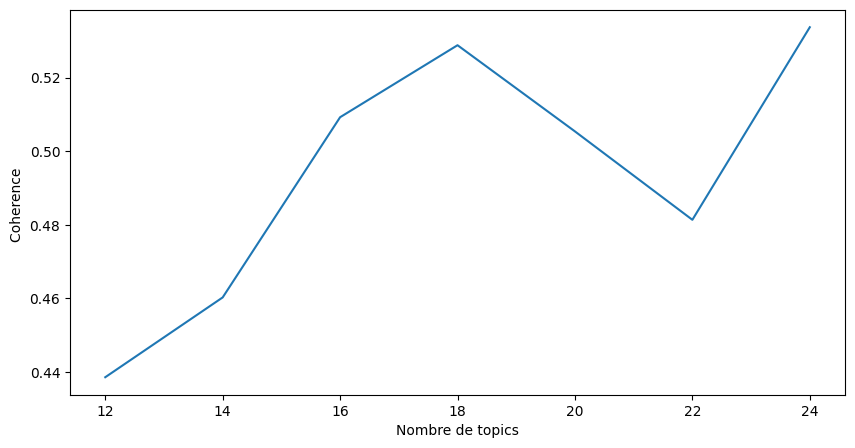

In [ ]:
# affichage du graphe associé à la recherche du nombre de topics
plt.figure(figsize=(10,5))
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Nombre de topics")
plt.ylabel("Coherence ")
#plt.legend(("Valeurs de cohérencescoherence_values"), loc='best')
plt.show()

Affichage des meilleurs topics pour le corpus BOW avec le modèle LDA

In [ ]:
num_topics=18 # nombre de topics
num_words=50 # nombre de mots par topics


lda_model_all = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus_all,
                           num_topics=num_topics,
                           id2word=dictionary_all,
                           chunksize=100,
                           workers=7, 
                            passes=10,
                            random_state=100,
                           eval_every = 1,
                           per_word_topics=True)


print ("Affichage des ",num_topics," différents topics pour le corpus BOW :\n")
for idx, topic in lda_model_all.print_topics(-1,num_words):
    print('Topic: {} Word: {}'.format(idx, topic))



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Affichage des  18  différents topics pour le corpus BOW :

Topic: 0 Word: 0.007*"say" + 0.004*"year" + 0.004*"trump" + 0.004*"go" + 0.003*"include" + 0.003*"government" + 0.003*"work" + 0.003*"report" + 0.003*"time" + 0.003*"well" + 0.003*"also" + 0.002*"vaccine" + 0.002*"see" + 0.002*"think" + 0.002*"self spread" + 0.002*"country" + 0.002*"new" + 0.002*"president" + 0.002*"month" + 0.002*"lead" + 0.002*"people" + 0.002*"state" + 0.002*"get" + 0.002*"come" + 0.002*"business" + 0.002*"plan" + 0.002*"release" + 0.002*"figure" + 0.002*"take" + 0.002*"look" + 0.002*"sell" + 0.002*"day" + 0.002*"national" + 0.002*"bill" + 0.002*"military" + 0.001*"long term" + 0.001*"use" + 0.001*"mean" + 0.001*"know" + 0.001*"make" + 0.001*"first" + 0.001*"support" + 0.001*"acre" + 0.001*"investment" + 0.001*"farmland" + 0.001*"storm overflow" + 0.001*"overflow" + 0.001*"way" + 0.001*"biden" + 0.001*"call"
Topic: 1 Word: 0.008*"say" + 0.005*"deputation" + 0.004*"astrazeneca" + 0.003*"military" + 0.003*"par

Formatage des topics en phrases pour les documents et création d'un dataframe de sortie

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Initialisation du dataframe de sortie
    sent_topics_df = pd.DataFrame()
    
    # Recherche le topic dominant pour chaque document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Donne le topic dominant, le pourcentage de contribution 
        # et les mots clés pour chaque document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => topic dominant
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['topic_dominant', 'pourcentage_contrib', 'topic_keywords']

    # Ajout du texte original à la fin de la sortie
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Création d'un dataframe avec les topics dominants et les mots clés associés pour chaque document

In [ ]:
df_all = df_all.reset_index(drop=True) # réinitialiser l'index en supprimant les anciennes valeurs d'index
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_all, corpus=corpus_all, texts=df_all.text)
display(df_topic_sents_keywords)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_dominant,pourcentage_contrib,topic_keywords,text
0,15,0.9941,"say, percent effective, vaccine, covid, includ...","During the predawn hours on New Year’s Day, De..."
1,14,0.4397,"say, vaccine, sar cov, volcano, virus, covid, ...",LONG-TERM MASK USE MAY CONTRIBUTE TO ADVANCED ...
2,7,0.6823,"say, people, vaccine, country, also, covid, vi...",The Biden administration will soon deliver a s...
3,11,0.4818,"say, case, people, human right, neighborhood, ...","As many as 45,000 people may have died from th..."
4,7,0.6476,"say, people, vaccine, country, also, covid, vi...",A Proof has recently appeared that cash attach...
...,...,...,...,...
837,9,0.6363,"say, trump, tata, city, agent, state, gate, us...",The man raises the recording device to his lip...
838,9,0.6482,"say, trump, tata, city, agent, state, gate, us...",Turkish land forces have advanced into Syria t...
839,14,0.8606,"say, vaccine, sar cov, volcano, virus, covid, ...",Health Minister Christian Dubé hopes the measu...
840,12,0.9749,"say, people, heat wave, year, woman, day, deat...","A customer leaves an SAQ outlet on Jan. 6, the..."


Ajout des mots clés associés au topic dominant dans le dataframe original

In [ ]:
# modification du dataframe pour intégrer les mots associés au topic dominant à chaque document
df_all['keywords']=df_topic_sents_keywords['topic_keywords']
display(df_all)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,public_id,text,title,our rating,ID,classe,keywords
0,NaN,"During the predawn hours on New Year’s Day, De...",Delta Force Raids Biden Compound in Ukraine,false,105625103119574386858328487241855757744,2,"say, percent effective, vaccine, covid, includ..."
1,f2fcb445,LONG-TERM MASK USE MAY CONTRIBUTE TO ADVANCED ...,FIRST CLASS Schools reopen with kids in masks ...,false,NaN,2,"say, vaccine, sar cov, volcano, virus, covid, ..."
2,8469a163,The Biden administration will soon deliver a s...,U.S. Senator Jeff Merkley of Oregon,false,NaN,2,"say, people, vaccine, country, also, covid, vi..."
3,NaN,"As many as 45,000 people may have died from th...",Top Cardiologist: Game-Changing Study Shows CO...,false,200049446239665258541118918005789068501,2,"say, case, people, human right, neighborhood, ..."
4,ae596f59,A Proof has recently appeared that cash attach...,The New York Times Affirms: ‘Soros & Clinton P...,false,NaN,2,"say, people, vaccine, country, also, covid, vi..."
...,...,...,...,...,...,...,...
837,NaN,The man raises the recording device to his lip...,Spain’s coronavirus deniers: ‘We are normal pe...,true,74468890951920551951630291730561107596,1,"say, trump, tata, city, agent, state, gate, us..."
838,NaN,Turkish land forces have advanced into Syria t...,Turkey Steps Up Offensive Against Syrian Kurdi...,true,147575044263640448705296981827539520951,1,"say, trump, tata, city, agent, state, gate, us..."
839,NaN,Health Minister Christian Dubé hopes the measu...,Quebec's liquor and cannabis stores will requi...,true,270077888906743054673881300019061126049,1,"say, vaccine, sar cov, volcano, virus, covid, ..."
840,NaN,"A customer leaves an SAQ outlet on Jan. 6, the...",Quebec’s expansion of COVID-19 vaccine passpor...,true,189700315351432315169761694613833047445,1,"say, people, heat wave, year, woman, day, deat..."


Comptage du nombre de fake news pour chaque sujet

In [ ]:
# Compter le nombre de fake news pour chaque sujet
fake_news_count = df_all[df_all['classe'] == 2].groupby('keywords')['classe'].count().sort_values(ascending=False)

# Afficher les résultats
print(fake_news_count)


keywords
say, people, vaccine, country, also, covid, virus, even, well, make                                                   88
say, year, trump, go, include, government, work, report, time, well                                                   46
say, child, people, vaccine, state, make, year, see, time, hospital                                                   42
say, case, people, human right, neighborhood, authority, kill, include, time, report                                  28
say, percent effective, vaccine, covid, include, use, public, yet, order, development                                 26
say, state, include, school, pandemic, kingdom, also, work, use, country                                              25
say, vaccine, sar cov, volcano, virus, covid, eruption, use, covid vaccine, biontech covid                            20
say, deputation, astrazeneca, military, part, officer, group, american oversight, deputize, report                    20
hide caption, capitol h

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# selection des données
X=df_all.keywords
y=df_all.classe

# Création d'un jeu d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# création du pipeline en ajoutant le classifier
pipe = Pipeline([
    ("cleaner", TextNormalizer(removestopwords=True, lowercase=True, removedigit=True, getstemmer=False, getlemmatisation=False)),
    ("TfidfVectorizer", TfidfVectorizer()), 
    ("classifier", SVC(C=1, gamma=0.001, kernel='linear'))
])
pipe.fit(X_train,y_train)


y_true, y_pred = y_test, pipe.predict(X_test)

print(classification_report(y_true, y_pred))
# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           1       0.53      0.62      0.57       127
           2       0.54      0.45      0.49       126

    accuracy                           0.54       253
   macro avg       0.54      0.54      0.53       253
weighted avg       0.54      0.54      0.53       253

Accuracy: 0.5375494071146245
